In [15]:
from torch import tensor
from pathlib import Path
from IPython.core.debugger import set_trace
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt

In [16]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [17]:
# The data is numpy arrays. We map them to tensors (GPU arrays)
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n,c= x_train.shape
n,c

(50000, 784)

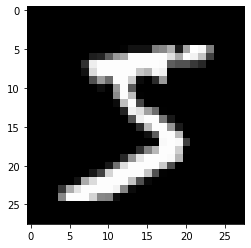

In [18]:
mpl.rcParams['image.cmap'] = 'gray'
img = x_train[0]
img.view(28,28).type()
plt.imshow(img.view((28,28))); # Reshape 784 into 28,28 array with view fn

## Model

In [19]:
weights = torch.randn(784,10)
bias =torch.zeros(10)

### Matrix multiplication

In [20]:
# Naive matrix multiplication
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

In [21]:
m1 = x_valid[:5]
m2 = weights
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [22]:
%time t1=matmul(m1, m2)

Wall time: 1.4 s


Naive is too slow : 1.2 s

In [23]:
# Vectorized matrix multiplication
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [24]:
%time t1=matmul(m1, m2)

Wall time: 2 ms


Vectorized one is : 3 ms

In [25]:
# Broadcasted matrix multiplication
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar,bc)
    for i in range(ar):
            c[i,:] = (a[i,:].unsqueeze(-1) * b).sum(dim=0)
    return c

In [26]:
%time t1=matmul(m1, m2)

Wall time: 1e+03 µs


Broadcast matmul time: 1 ms

In [27]:
%time m1.numpy()@m2.numpy()

Wall time: 0 ns


array([[  5.691075  ,  16.28933   ,   2.0140808 ,   7.357096  ,
          0.81534195,  21.364254  , -10.218528  ,   7.9916844 ,
          3.7460508 ,   3.9860883 ],
       [ -4.3225937 ,  18.572964  ,   1.515564  ,   2.6239016 ,
         -1.7383683 ,  13.750866  ,  -7.2006044 ,  10.845543  ,
        -11.297068  ,  -0.12869501],
       [ -5.944226  ,  17.293951  ,   8.172461  ,   9.334679  ,
         14.084606  ,   8.181305  ,  -9.832958  ,   2.4618044 ,
          5.202966  ,  13.087377  ],
       [ -0.97929037,   7.8528957 ,  -5.1944036 ,  16.07204   ,
         11.829055  ,   7.6489954 ,   0.8262379 ,  10.302209  ,
          0.73990095,   2.2615309 ],
       [ -6.5095615 ,   3.6197429 ,  -7.1315413 ,   2.4847035 ,
          1.4356837 ,   6.7887545 ,   5.331416  ,   6.3902407 ,
          0.2979517 ,   8.059476  ]], dtype=float32)

Numpy: 3ms

In [28]:
%time torch.mm(m1,m2)

Wall time: 0 ns


tensor([[  5.6911,  16.2893,   2.0141,   7.3571,   0.8153,  21.3643, -10.2185,
           7.9917,   3.7461,   3.9861],
        [ -4.3226,  18.5730,   1.5156,   2.6239,  -1.7384,  13.7509,  -7.2006,
          10.8455, -11.2971,  -0.1287],
        [ -5.9442,  17.2940,   8.1725,   9.3347,  14.0846,   8.1813,  -9.8330,
           2.4618,   5.2030,  13.0874],
        [ -0.9793,   7.8529,  -5.1944,  16.0720,  11.8291,   7.6490,   0.8262,
          10.3022,   0.7399,   2.2615],
        [ -6.5096,   3.6197,  -7.1315,   2.4847,   1.4357,   6.7888,   5.3314,
           6.3902,   0.2980,   8.0595]])

In [29]:
m1.cuda()
m2.cuda()

tensor([[-0.1297, -0.6752,  0.6991,  ..., -1.1065,  0.8888, -0.3337],
        [ 1.6245, -1.4033, -0.1889,  ...,  1.5594, -1.5090, -0.8083],
        [ 0.1510,  0.9005, -0.3396,  ..., -0.5043, -0.1400, -0.6479],
        ...,
        [ 0.6361, -1.2299, -1.0664,  ..., -0.7709,  1.0842,  0.6286],
        [-0.5253, -0.5351,  0.7478,  ..., -0.1662,  0.0318, -0.7482],
        [ 1.5735,  0.6596, -1.2726,  ..., -1.7777,  0.2311,  0.6456]],
       device='cuda:0')

In [30]:
%time torch.mm(m1,m2)

Wall time: 0 ns


tensor([[  5.6911,  16.2893,   2.0141,   7.3571,   0.8153,  21.3643, -10.2185,
           7.9917,   3.7461,   3.9861],
        [ -4.3226,  18.5730,   1.5156,   2.6239,  -1.7384,  13.7509,  -7.2006,
          10.8455, -11.2971,  -0.1287],
        [ -5.9442,  17.2940,   8.1725,   9.3347,  14.0846,   8.1813,  -9.8330,
           2.4618,   5.2030,  13.0874],
        [ -0.9793,   7.8529,  -5.1944,  16.0720,  11.8291,   7.6490,   0.8262,
          10.3022,   0.7399,   2.2615],
        [ -6.5096,   3.6197,  -7.1315,   2.4847,   1.4357,   6.7888,   5.3314,
           6.3902,   0.2980,   8.0595]])